# Smoothing Splines

Smoothing splines provide a way to fit a smooth curve to a set of data points. The idea behind the method is to find a curve that balances the fit to the data against its roughness, with the level of smoothing controlled by a parameter, $\lambda$.

## Mathematical Formulation

The smoothing spline is obtained by minimizing the following penalized residual sum of squares:

$$
RSS_\lambda = \sum_{i=1}^n (y_i - f(x_i))^2 + \lambda \int [f''(x)]^2 dx
$$

Here:
- The first term $\sum_{i=1}^n (y_i - f(x_i))^2$ is the residual sum of squares that measures the fit of the curve to the data.
- The second term $\lambda \int [f''(x)]^2 dx$ is a penalty for roughness, where $f''(x)$ is the second derivative of the function. The integral measures the roughness of the curve.
- $\lambda$ is a smoothing parameter that controls the trade-off between the fit and smoothness. When $\lambda = 0$, the spline is an interpolating spline that passes through each data point. As $\lambda \rightarrow \infty$, the spline approaches a straight line.

## Generalized Cross-Validation (GCV)

To select a good value of $\lambda$, we can use the Generalized Cross-Validation (GCV) criterion:

$$
GCV(\lambda) = \frac{RSS(\lambda)/n}{(1-\text{df}(\lambda)/n)^2}
$$

Where:
- $RSS(\lambda)$ is the residual sum of squares for a given $\lambda$.
- $\text{df}(\lambda)$ is the effective degrees of freedom for a given $\lambda$.
- $n$ is the number of observations.

The goal is to choose the $\lambda$ that minimizes the GCV criterion.

## Confidence Intervals

For any predicted value $\hat{f}(x_i)$, the 95% confidence interval is given by:

$$
\hat{f}(x_i) \pm 1.96 \times SE(\hat{f}(x_i))
$$

Where $SE(\hat{f}(x_i))$ is the standard error of the predicted value at $x_i$.

<b>Reference:</b> From GaTech ISYE 8803 High Dimensional Data Analytics lecture notes, enhanced with ChatGPT.

Best lambda:  397.0001


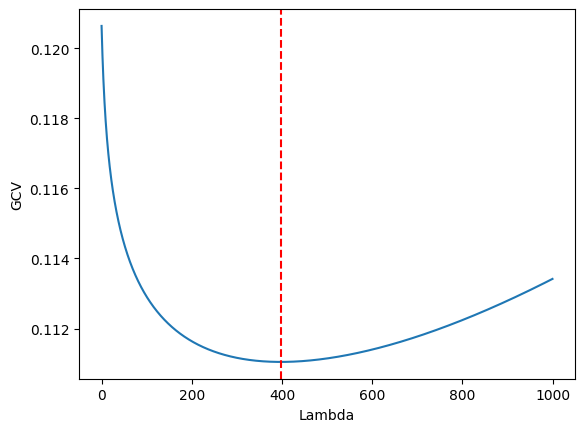

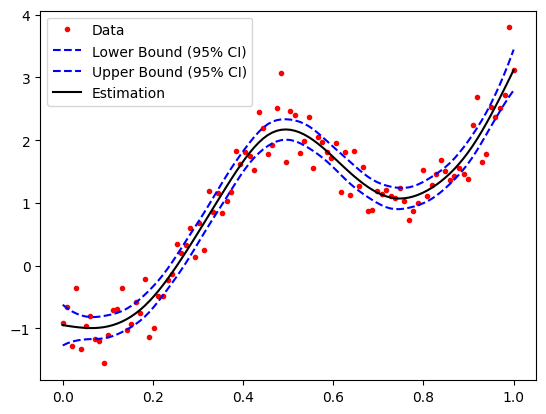

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import patsy

# Generate data
n = 100
D = np.linspace(0, 1, n)
sigma = 0.3
fun = lambda x: 2.5 * x - np.sin(10 * x) - np.exp(-10 * x)
y = fun(D) + np.random.randn(n) * sigma

# Generate B-spline basis using patsy
M = 4  
K = 12  
knots = np.linspace(0, 1, K)
B = patsy.bs(D, knots=knots[1:-1], degree=M-1, include_intercept=True)

# Difference matrices
D1 = np.diff(B, axis=0)
D2 = np.diff(D1, axis=0)

# Lambda selection
alllambda = np.arange(0.0001, 1000, 0.5)
L = len(alllambda)
RSS = np.zeros(L)
df = np.zeros(L)

for i in range(L):
    S = B @ np.linalg.inv(B.T @ B + alllambda[i] * D2.T @ D2) @ B.T
    yhat = S @ y
    RSS[i] = np.sum((yhat-y)**2)
    df[i] = np.trace(S)
    
# GCV criterion
n = len(y)
GCV = (RSS/n)/((1-df/n)**2)

# Best lambda
best_lambda = alllambda[np.argmin(GCV)]
print("Best lambda: ", best_lambda)

# Plot lambda
plt.plot(alllambda, GCV)
plt.axvline(x=best_lambda, color='red', linestyle='--')
plt.xlabel('Lambda')
plt.ylabel('GCV')
plt.show()

# Compute estimates with best lambda
S_best = B @ np.linalg.inv(B.T @ B + best_lambda * D2.T @ D2) @ B.T
yhat_best = S_best @ y

# Compute residuals
res = y - yhat_best

# Compute variance of residuals
K = np.trace(S_best)
sigma2 = np.var(res, ddof=int(K))

# Compute standard error for each prediction
se = np.sqrt(np.diag(sigma2 * S_best))

# Compute the lower and upper bounds for the confidence intervals
yn = yhat_best - 1.96 * se
yp = yhat_best + 1.96 * se

# Plot function:
plt.plot(D, y, 'r.', label='Data')
plt.plot(D, yn, 'b--', label='Lower Bound (95% CI)')
plt.plot(D, yp, 'b--', label='Upper Bound (95% CI)')
plt.plot(D, yhat_best, 'k-', label='Estimation')
plt.legend()
plt.show()